<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº2: Sistemas Lineales e Invariantes en el tiempo
#### María Victoria Poric

## Introducción Teórica

En el análisis de sistemas dinámicos resulta fundamental comprender la relación entre señales de entrada y de salida a través de modelos matemáticos. En el ámbito de sistemas lineales invariantes en el tiempo (LTI), esta relación queda caracterizada por la respuesta al impulso, la cual permite determinar la salida frente a cualquier señal de entrada mediante el principio de convolución discreta. De este modo, una vez conocida la respuesta al impulso, es posible analizar el comportamiento del sistema frente a señales periódicas, pulsos o modulaciones, y calcular parámetros de interés como energía o potencia.

En este contexto, un método usual para describir sistemas discretos es el uso de ecuaciones en diferencias, que son la contraparte en tiempo discreto de las ecuaciones diferenciales. Estas expresiones relacionan muestras actuales y pasadas de la salida con muestras de la entrada, permitiendo representar sistemas causales de manera sencilla. Así, a partir de una ecuación en diferencias, se pueden obtener directamente tanto la respuesta impulsional como la salida del sistema ante cualquier señal de entrada.

En paralelo, los modelos fisiológicos también pueden describirse a partir de ecuaciones diferenciales. Un ejemplo clásico es el modelo Windkessel, que representa la dinámica presión-flujo en el sistema arterial, considerando parámetros como la compliance vascular ($C$) y la resistencia periférica ($R$). Dicho modelo se expresa mediante una ecuación diferencial ordinaria de primer orden que puede discretizarse mediante métodos numéricos, lo que permite simular digitalmente la evolución temporal de la presión arterial frente a un flujo sanguíneo pulsátil.

Ambos enfoques, ecuaciones en diferencias en sistemas LTI y discretización de modelos fisiológicos, muestran la importancia de las herramientas matemáticas y computacionales para describir, simular y comprender fenómenos de distinta naturaleza pero con una base común: la interacción entre una entrada y la dinámica interna del sistema.

## Análisis y desarrollo

Para comenzar con el desarrollo del código se procedió a definir las funciones a utilizar para el punto 1 de la tarea. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

def sist_lti(x, y0=(0.0, 0.0)): #y0 son las cond iniciales(les doy cero pq es causal)
    x = np.asarray(x, dtype = float)
    N = len(x)
    y = np.zeros(N, dtype = float)
    entrada_final = np.zeros(N, dtype = float)
    retroalim_final = np.zeros(N, dtype = float)
    
    #coeficientes
    e0, e1, e2 = 0.03, 0.05, 0.03
    r0, r1 = 1.5, -0.5
    
    #condiciones iniciales
    y1, y2 = y0
    
    for n in range(N):
        #entrada
        xn0 = x[n]
        xn1 = x[n-1] if n-1 >=0 else 0.0 
        xn2 = x[n-2] if n-2 >=0 else 0.0 
        
        entrada = e0 * xn0 + e1 * xn1 + e2 * xn2
        
        #retroalimentacion
        yn1 = y[n-1] if n-1 >=0 else y1
        yn2 = y[n-2] if n-2 >=0 else y2
        
        retroalim = r0 * yn1 + r1 * yn2
        
        #salida total 
        y[n] = entrada + retroalim
        
        entrada_final[n] = entrada
        retroalim_final[n] = retroalim
        
    return y, entrada_final, retroalim_final

def f_senoidales(amp_max, offset, frec, fase, N, frec_ADC):
    Ts = 1 / frec_ADC #[s]
    n = np.arange(N) #índices de 0 a N-1
    tt = n * Ts                 
    xx = amp_max * np.sin(2*np.pi*frec*tt + fase) + offset
    
    return tt, xx

def recorta_amplitud(x, ratio = 0.75):
    # recorta por pico: c = ratio * max|x|
    #75% de la amplitud(pico)
    c = ratio * np.max(np.abs(x))
    return np.clip(x, -c, c)

La función **sist_lti** crea una ecuación en diferencias. Convierte los valores de x en un array de números, le da la longitud N de la cantidad de elementos de la señal que se ingrese. Luego, $y$, **entrada_final** y **retroalim_final** también son vectores del largo de N. Se prosigue declarando el valor de los coeficientes(los que son del tipo e y un número son de entrada y los de r y un número son de retroalimentación) y las condiciones iniciales, que en este caso son cero ya que se ausme que son funciones causales. A continuación, se crea un bucle $for$ donde se iterará según la cantidad de elementos del vector de la señal(es decir N) y se divide en dos las cuentas de la entrada y la retroalimentación para luego crear la salida total(vector $y$) y guardar los valores de entrada y retroalimentación de cada iteración. Por último se devuelven los valores de salida, entrada y retroalimentación. 

Luego, tanto **f_senoidales** como **recorta_amplitud** son funciones utilizadas previamente para la TS1. La primera crea señales senoidales y la segunda es de utilidad para la señal 4 de la TS1 que estaremos utilizando en este trabajo. 

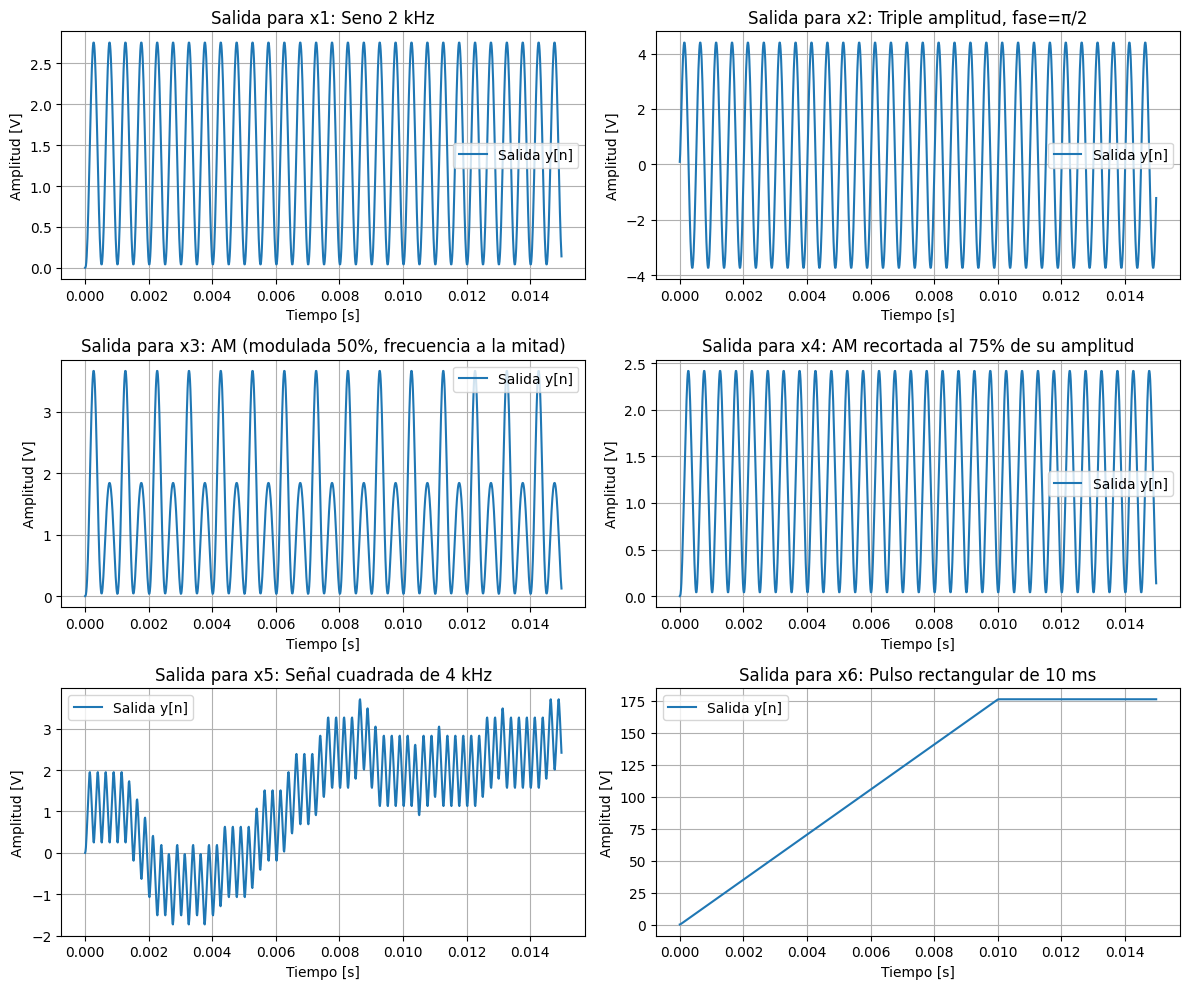

In [2]:
frec_ADC = 80000
N = 1200
Ts = 1 / frec_ADC
t, _ = f_senoidales(0, 0, 1, 0, N, frec_ADC)

amp_max = 1

#2.1 Señal senoidal de 2000 Hz
f1 = 2000

t, x1 = f_senoidales(amp_max, 0, f1, 0, N, frec_ADC)

#2.2 Misma señal amplificada y desfasada pi/2
fase = np.pi / 2
_, x2 = f_senoidales(3*amp_max, 0, f1, fase, N, frec_ADC)

#2.3 Misma señal modulada en amplitud por seno de la mitad de la frecuencia
m = 0.5
f_mod = f1 / 2
mod = 1 + m*np.sin(2*np.pi*f_mod*t) #envolvente AM
x3 = mod * (amp_max*np.sin(2*np.pi*f1*t)) #AM aca esta la multiplicacion de los senos


#2.4 Señal anterior recortada a 75% de su amplitud
x4 = recorta_amplitud(x1, ratio = 0.75)

#2.5 Señal cuadrada de 4 kHz(amplitud amp_max, valores + o - amp_max)
x5 = amp_max * np.sign(np.sin(2*np.pi*4000*t)) 

#2.6 Pulso rectangular de 10 ms (amplitud amp_max)
x6 = np.zeros_like(t)
t0, ancho = 0.00, 0.010          # de 0 a 10 ms
mask = (t >= t0) & (t < t0 + ancho)
x6[mask] = amp_max

senales_TS1 = {
    "x1: Seno 2 kHz":x1,
    "x2: Triple amplitud, fase=π/2":x2,
    "x3: AM (modulada 50%, frecuencia a la mitad)":x3,
    "x4: AM recortada al 75% de su amplitud":x4,
    "x5: Señal cuadrada de 4 kHz":x5,
    "x6: Pulso rectangular de 10 ms":x6,
}

plt.figure(figsize=(12, 10))
for i, (nombre, x) in enumerate(senales_TS1.items(), 1):
    y_rtdo, e_rtdo, r_rtdo = sist_lti(x)
    plt.subplot(3, 2, i)
    plt.plot(t, y_rtdo, label="Salida y[n]")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [V]")
    plt.title(f"Salida para {nombre}")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

Continuando con lo estimado para la tarea, se usaron las señales utilizadas en el anterior trabajo. Y mediante un ciclo *for* se procedió a que cada señal se utilize como valores de entrada para el sistema de ecuaciones en diferencia y se graficó su salida.

En cuanto a los gráficos observados, se puede concluir que tiene sentido lo que se observa al estarse graficando la salida de un sistema LTI. En el caso de la primera y segunda salida se observa un seno con los parámetros inciales y el otro desfasado y amplificado pero un poco distorsionado por el sistema. En cuanto a la tercera y cuarta señal, la salida conserva la forma modulada pero la envolvente ya no es la misma que la entrada. Para la quinta señal se observa una senoidal oscilante superpuesta y deja de ser cuadrada ya que los sistemas LTI filtran los armónicos de la señal cuadrada. Por último, para el pulso solo en el intervalo de 10 ms crece rápidamente y luego no vuelve a cero nuevamente ya que tiene los valores de retroalimentación que al ser los únicos valores que tienen asignados un valor númerico, ya que los valores de entreda pasan a ser cero, se mantiene constante en ese último valor que alcanzó.   

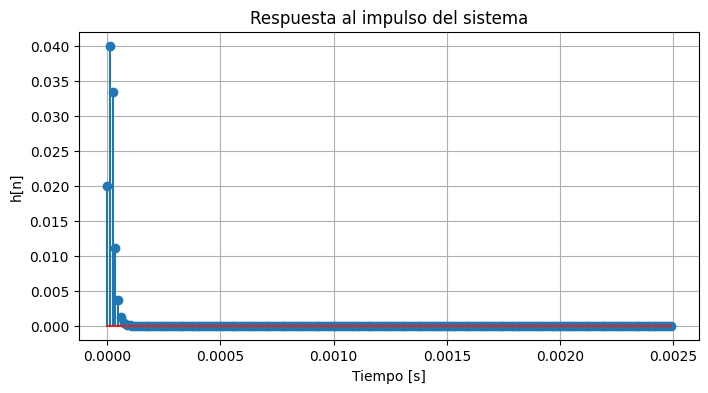

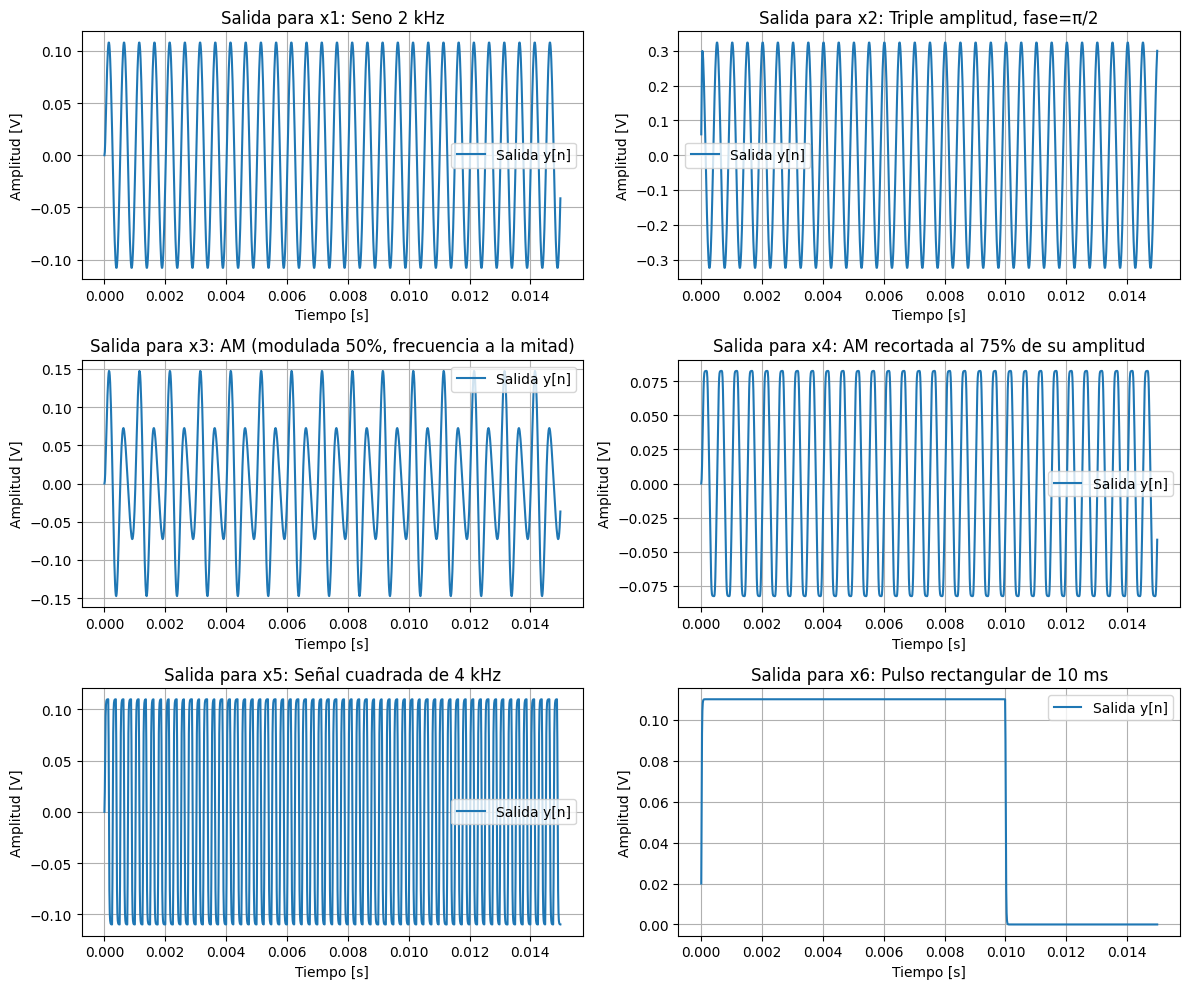

Resultados:
x1: Seno 2 kHz                 -> Potencia = 5.860378e-03
x2: Triple amplitud, fase=π/2  -> Potencia = 5.257016e-02
x3: AM (modulada 50%, frecuencia a la mitad) -> Potencia = 6.587822e-03
x4: AM recortada al 75% de su amplitud -> Potencia = 4.326313e-03
x5: Señal cuadrada de 4 kHz    -> Potencia = 9.198030e-03
x6: Pulso rectangular de 10 ms -> Energía = 0.000121


In [11]:
N_impulso = 200
delta = np.zeros(N_impulso)
delta[0] = 1.0
e = [0.03, 0.05, 0.03]
r = [1.5, -0.5]
h = lfilter(e, r, delta)

plt.figure(figsize=(8,4))
plt.stem(np.arange(N_impulso)*Ts, h)
plt.xlabel("Tiempo [s]")
plt.ylabel("h[n]")
plt.title("Respuesta al impulso del sistema")
plt.grid(True)
plt.show()

resultados = {}
plt.figure(figsize=(12, 10))
for i, (nombre, x) in enumerate(senales_TS1.items(), 1):
    # salida usando la respuesta al impulso
    y = np.convolve(x, h)[:len(x)]
    t_conv = np.arange(len(y)) * Ts
    
    # energía o potencia según corresponda
    if "Pulso" in nombre:  # caso x6
        medida = np.sum(y**2) * Ts
        resultados[nombre] = {"energia": medida}
    else:  # senoidales, cuadrada, AM
        medida = np.mean(y**2)
        resultados[nombre] = {"potencia": medida}
    
    plt.subplot(3,2,i)
    plt.plot(t_conv, y, label="Salida y[n]")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [V]")
    plt.title(f"Salida para {nombre}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

print("Resultados:")
for nombre, vals in resultados.items():
    if "energia" in vals:
        print(f"{nombre:30s} -> Energía = {vals['energia']:.6f}")
    else:
        print(f"{nombre:30s} -> Potencia = {vals['potencia']:.6e}")

Para el item 2 del primer punto en primer lugar se calculó la respuesta al impulso usando $lfilter$ y dando como parámetros los coeficientes de entrada y retroalimentación del sistema LTI definido. Luego se graficó esa respuesta al impulso sin darle valores de entrada de ninguna señal. 

A continuación mediante un ciclo *for* se graficaron las señales de salida utilizando las señales de entrada de la TS1 y el producto de convolución mediante *np.convolve* y la respuesta al impulso calculada previamente. Asimismo, en el ciclo, se calcularon los valores de energía y potencia. En el único caso que se calculó energía fue en el pulso rectangular de 10 ms ya que la duración de la señal es finita. En los demás casos, al ser la duración de la señal infinta, se calculó su energía. 

En cuanto a los gráficos plasmados, el sistema se comporta como un filtro pasa bajos. Para la primera señal de salida, se observa una forma senoidal pero con una ligera modificación en la fase y la amplitud respecto a la entrada, esto se debe a lo mencionado previamente de la actuación del sistema como un filtro. La segunda señal se comporta de manera similar a esta, ya que es la misma señal, amplficada y desfasada. Que el valor de la potencia sea nueve veces el valor de la potencia de la primera, comprueba que el sistema es lineal, ya que al triplicar la amplitud al elevar al cuadrado, se multiplica por nueve la potencia de la primera señal. Para la tercera señal, se observa la envolvente modulada y cierta distorsión en la amplitud. Sucede algo similar para la cuarta señal. En el caso de la quinta señal, la señal cuadrada tiene muchos armónicos, y el sistema atenúa muchos de ellos, es por eso que la señal se ve más "redondeada" o senoidal, en vez de verla como una cuadrada. Por último para la sexta señal, la salida es una respuesta transitoria, el pulso excita al sistema y se ve como responde mientras dura, es decir, en ese intervalo de 10 ms. 

In [7]:
def LTI2(x, N_imp = 50):
    #coeficientes
    e = np.zeros(11)
    e[0] = 1.0 
    e[10] = 3.0 
    r = [1]
    
    #salida para la señal de entrada
    y = lfilter(e, r, x)
    
    #rta al impuslo
    delta = np.zeros(N_imp)
    delta[0] = 1
    h = lfilter(e, r, delta)
        
    return y, h

def LTI3(x, N_imp = 50):
    #coeficientes
    e = [1]
    r = np.zeros(11)
    r[0] = 1.0 
    r[10] = -3.0 
    
    #salida para la señal de entrada
    y = lfilter(e, r, x)
    
    #rta al impuslo
    delta = np.zeros(N_imp)
    delta[0] = 1
    h = lfilter(e, r, delta)
        
    return y, h

Para el punto 2 se definieron los dos sistemas pedidos para comenzar con esta tarea. En ambos casos se definieron los coeficientes de entrada(denotados con la letra $e$) y de retroalimentación(denotados con la letra $r$). Para la salida se utilizó $lfilter$ para mayor practicidad. Y se calculó la respuesta al impulso, que junto a la salida, fueron los valores devueltos por el siemta. 

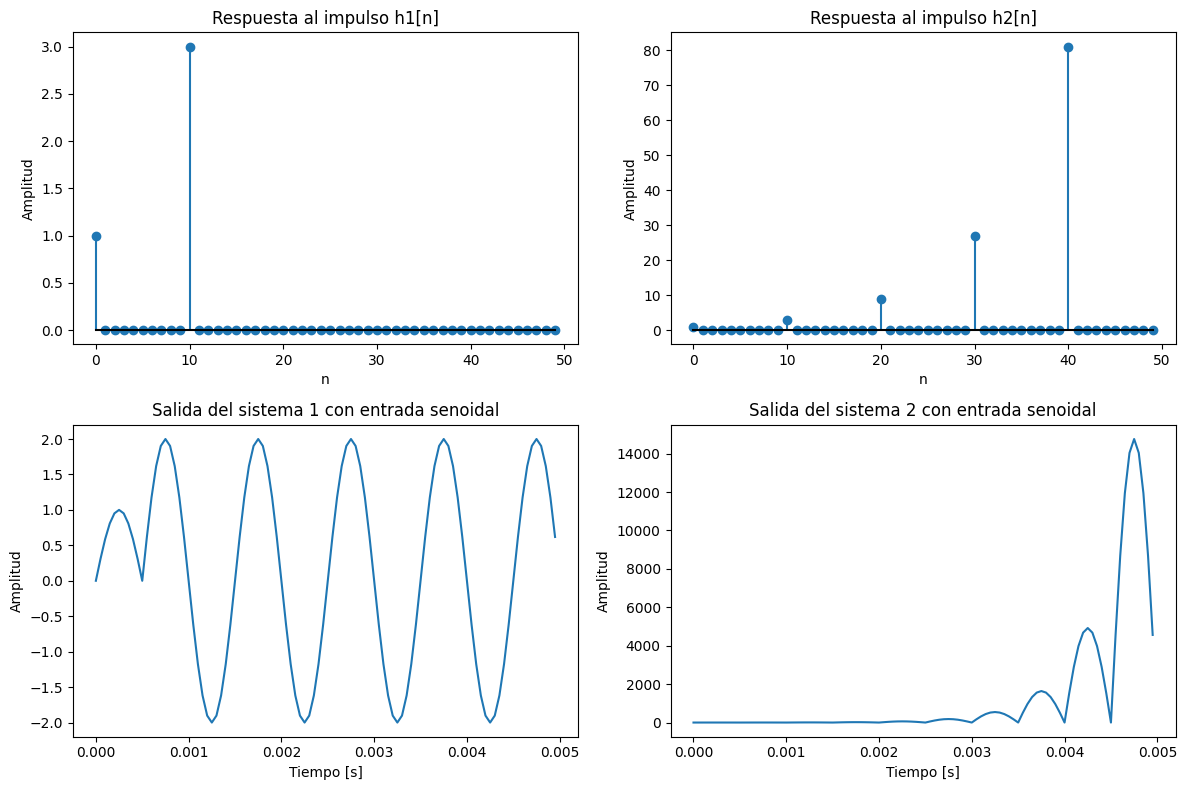

In [8]:
N = 100
frec_ADC = 20000
t = np.arange(N) / frec_ADC

f0 = 1000 
x_pto2 = np.sin(2*np.pi*f0*t)

y_pto2_1, h_pto2_1 = LTI2(x_pto2)
y_pto2_2, h_pto2_2 = LTI3(x_pto2)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.stem(h_pto2_1, basefmt="k")
plt.title("Respuesta al impulso h1[n]")
plt.xlabel("n"); plt.ylabel("Amplitud")

plt.subplot(2,2,2)
plt.stem(h_pto2_2, basefmt="k")
plt.title("Respuesta al impulso h2[n]")
plt.xlabel("n"); plt.ylabel("Amplitud")

plt.subplot(2,2,3)
plt.plot(t, y_pto2_1)
plt.title("Salida del sistema 1 con entrada senoidal")
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud")

plt.subplot(2,2,4)
plt.plot(t, y_pto2_2)
plt.title("Salida del sistema 2 con entrada senoidal")
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Para este procedimiento se dieron paramétros de una senoidal cualquiera y se graficó la señal de salida para ambos sistemas.

En cuanto a la respuesta al impulso, para el sistema 1 se obtiene: 
$$
h_1[n] = \delta[n] + 3 \delta[n-10]
$$
En el gráfico se observan dos picos, uno en $n=0$ con amplitud $1$ y otro en $n=10$ con amplitud $3$.

Luego, para el sistema 2, la retroalimentación genera una respuesta al impulso recursiva:
$$
h_2[n] = \sum_{k=0}^{\infty} 3^k \,\delta[n-10k]
$$
En el gráfico se observan valores de $n=0,10,20,...$ con amplitudes $1,3,9,27,...$ mostrando el crecimiento exponencial y anticipando la inestabilidad.

Para el sistema 1, el retardo de 10 muestras introduce un desfase de $\pi$ radianes a 1 kHz, por lo que 
$$
x[n-10]=-x[n]
$$
y la salida es 
$$
y[n]=-2x[n]
$$
es decir que la señal de salida resulta invertida y con amplitud doblada. 

Para el sistema 2, se puede observar que el sistema es inestable y su salida ante una entrada senoidal crece exponencialmente conforme actúa la retroalimentación retardada. 

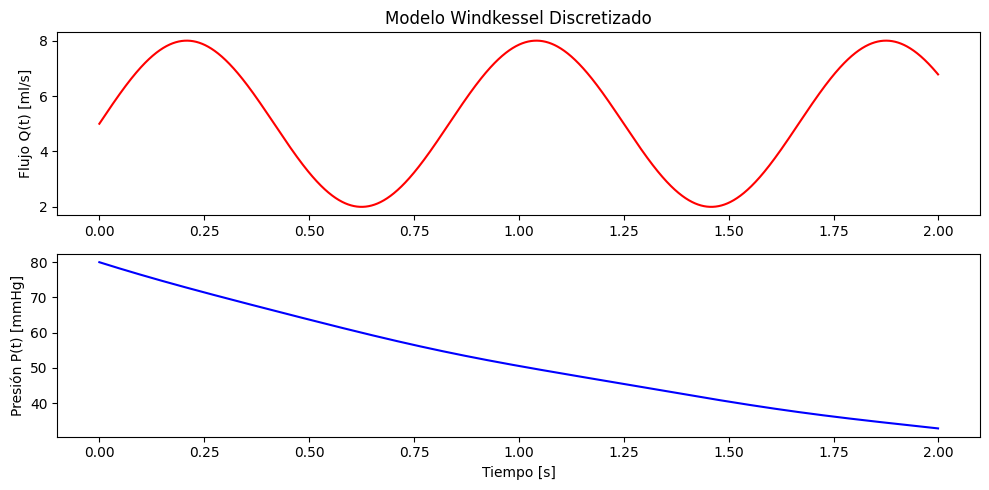

In [12]:
#BONUS

# Parámetros fisiológicos típicos
C = 2.0   # Compliance (ml/mmHg)
R = 1.0   # Resistencia (mmHg·s/ml)

# Tiempo de simulación
dt = 0.001   # paso temporal (s)
Tmax = 2     # tiempo total (s)
t = np.arange(0, Tmax, dt)

# Flujo de entrada Q(t) (ml/s) - simulamos pulso cardíaco con senoides
f_cardiaca = 1.2   # frecuencia cardíaca (Hz, ~72 lat/min)
Q = 5 + 3*np.sin(2*np.pi*f_cardiaca*t)  # flujo pulsátil

# Inicializamos presión
P = np.zeros_like(t)
P[0] = 80   # Presión inicial (mmHg)

# Iteramos con método de Euler
for n in range(len(t)-1):
    dPdt = (1/C)*(Q[n] - P[n]/R)
    P[n+1] = P[n] + dt*dPdt

# Graficamos resultados
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(t, Q, 'r')
plt.ylabel("Flujo Q(t) [ml/s]")
plt.title("Modelo Windkessel Discretizado")

plt.subplot(2,1,2)
plt.plot(t, P, 'b')
plt.xlabel("Tiempo [s]")
plt.ylabel("Presión P(t) [mmHg]")

plt.tight_layout()
plt.show()

Para el punto Bonus, en primer lugar se discretizó la ecuación. La ecuación original es:
$$
C \cdot \frac{dP}{dt} + \frac{1}{R} P(t) = Q(t)
$$
donde $C$ es la **compliance vascular** $[ml/mmHg]$, $R$ es la **resistencia vascular** $[mmHg s/ml]$, $P(t)$ es la **presión arterial** $[mmHg]$ y $Q(t)$ es el **flujo sanguíneo** $[ml/s]$. 

Luego, aislamos la derivada
$$
\frac{dP}{dt} = \frac{1}{C} \left( Q(t) - \frac{1}{R} P(t) \right)
$$

Para discretizar en el tiempo, se considera el paso temporal $\Delta t$ y se aproxima 
$$
\frac{dP}{dt} \approx \frac{P[n+1] - P[n]}{\Delta t}
$$
donde $P[n] \equiv P(n \cdot \Delta t)$.

A continuación se reemplaza la aproximación en la ecuación:
$$
\frac{P[n+1] - P[n]}{\Delta t} = \frac{1}{C}\left( Q[n] - \frac{1}{R} P[n] \right)
$$

Por último, se obtiene la expresión recursiva para la presión
$$
P[n+1] = P[n] + \Delta t \cdot \frac{1}{C} \left( Q[n] - \frac{1}{R} P[n] \right)
$$
Esta es la forma discreta de la ecuación, implementada numéricamente mediante el método de Euler explícito.

Luego, en el código se dan valores típicos de flujo sanguíneo y se simula el pulso cardíaco con valores senoidales. 

## Conclusiones

A partir del desarrollo realizado, se observa que la caracterización de un sistema mediante su respuesta al impulso constituye una herramienta poderosa para predecir y analizar el comportamiento ante diferentes señales de entrada. En particular, se verificó que la salida puede calcularse directamente a través de la convolución con la respuesta al impulso, y que el análisis energético y de potencia permite clasificar adecuadamente señales finitas y periódicas.

Por otro lado, la discretización del modelo de Windkessel permitió trasladar una ecuación diferencial fisiológica a un esquema numérico implementable en computadora. La aplicación del método de Euler explícito mostró cómo la presión arterial evoluciona en función del flujo de entrada y de los parámetros $C$ y $R$, proporcionando una aproximación simple pero efectiva de la dinámica cardiovascular.

En síntesis, tanto en el estudio de sistemas eléctricos o de procesamiento de señales como en la modelización de fenómenos fisiológicos, el enfoque de sistemas discretos y el uso de respuestas impulsionales o esquemas numéricos constituyen herramientas clave para el análisis y la simulación en entornos académicos y aplicados.

## Autoevaluación del aprendizaje

Para esta tarea considero que la parte del código fue mucho más facil de hacer, era quizas más intuitiva y casi todo pude plantearlo yo desde un comienzo y si algo no funcionaba ahi acudía a Chat GPT. También utilicé inteligencia artificial para ayudarme a comprender la interpretación de los gráficos y para poder escribir en LaTeX. Luego del análisis creo que comprendí mejor como funcionan las ecuaciones en diferencias y la respuesta al impulso. 

Al principio tampoco entendía la relación del Bonus con el resto de la tarea, pero creo que se debe a que es una ecuación diferencial y nos sirve también para, por lo menos yo, el estudio de Ingeniería Biomédica. 